# 06. PyTorch Transfer Learining

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model - foundational models

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


Let's importt code we've written in previous notebooks

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 34.80 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Get data

We need our pizza, steak, sushi data to build a transfer learning model.

In [ ]:
import os
import zipfile

from pathlib import Path
import requests

# Setup path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If image folder doesn't exist download and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download")
else:
  print(f"Did not find {image_path} downloading...")

  image_path.mkdir(parents=True, exist_ok=True)

  # Download data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Donwloading...")
    f.write(request.content)

  # unzip
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as z:
    print("unzipping data...")
    z.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi downloading...
Donwloading...
unzipping data...


In [ ]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and `create_dataloader()` function we made in 05 pytorch going modular.

There's one thing we have to think about when loading: how to **transform** it?

1. Manually create transforms - you define what transforms you want your data to go through
2. Automatically created transfomrs - transforms for your data are defined by the model you'd like to use.

Important point- when using a pretrained model, it's important that the data (including custom data) that you can pass through it is **transformed** in the same way that the data the model was trained on.

### 2. Create a transfrom for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`

In [ ]:
from torchvision import transforms

# From documentation
normalize = transforms.Normalize(mean=[0.485,0.465,0.406],
                                 std=[0.229,0.224,0.225])
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), # Get images in range[0,1]
    normalize # make sure images have the same distribution as ImageNet
])


In [ ]:
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ee9c1d27b90>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating transfomr for `torchvision.models` (auto creation)

Automatic data transform creation based on pretrained model weights you're using.

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  #"Default" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get transfomrs used to create pretrained weights
auto_transforms =  weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create dataloaders using automatic transforms

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir= test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ee9c0c3f610>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get pretrained models, such as:

1. PyTorch domain libraries
2. Libraries like `timm` (PyTorch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Whch pretrained model should you use?

*Experiment*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - How fast does it run?
2. Size - How big is the model?
3. Performance - How well does it go on your chosen problem (eg. how well does it classify images? {for FoodVision mini})

Where does the model live?
Is it on device? (like a self-driving car)
Or does it live on a server?

For our case EffNetB0 is one of our best option in terms of performancs vs size

However, in light of **THE BITTER LESSON**, if we had infinite compute,we'd likely pick the biggest model + most parameters we could.


### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained EfficientNet_B0_Weights

In [ ]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# model = torchvision.models.efficientnet_b0(pretrained=True)
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
# Print with torchinfo

from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224), # Example of [batch_size,color_channel,h,w]
        col_names=["input_size","output_size","num_params","trainable"],
        col_width =20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of a pretrained/foundational model and update the output layers to suit your own problem.

In [ ]:
# Freeze all of the base layers in EffNetB0
for params in model.features.parameters():
  params.requires_grad =False

In [ ]:
# Update the classifier head of our model to suit our problem

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True), # Dropout - will drop (0.2 -> 20% ) neurons to prevent overfittting (increase genrelizaion), # inplace=True -> dropout will be applied directly to input tensor(dropping 20% neurons)and original tensor will be modified in place, saving memory
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model,
        input_size=(1,3,224,224), # Example of [batch_size,color_channel,h,w]
        col_names=["input_size","output_size","num_params","trainable"],
        col_width =20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
%%time
# Import train function
from going_modular.going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End time and print out how long it took
end_time=timer()
print(f"[INFO] Total training time: {end_time-start_time}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 14.305795820000014
CPU times: user 1.93 s, sys: 777 ms, total: 2.7 s
Wall time: 14.3 s


## 5. Evaluating by plottting loss curves

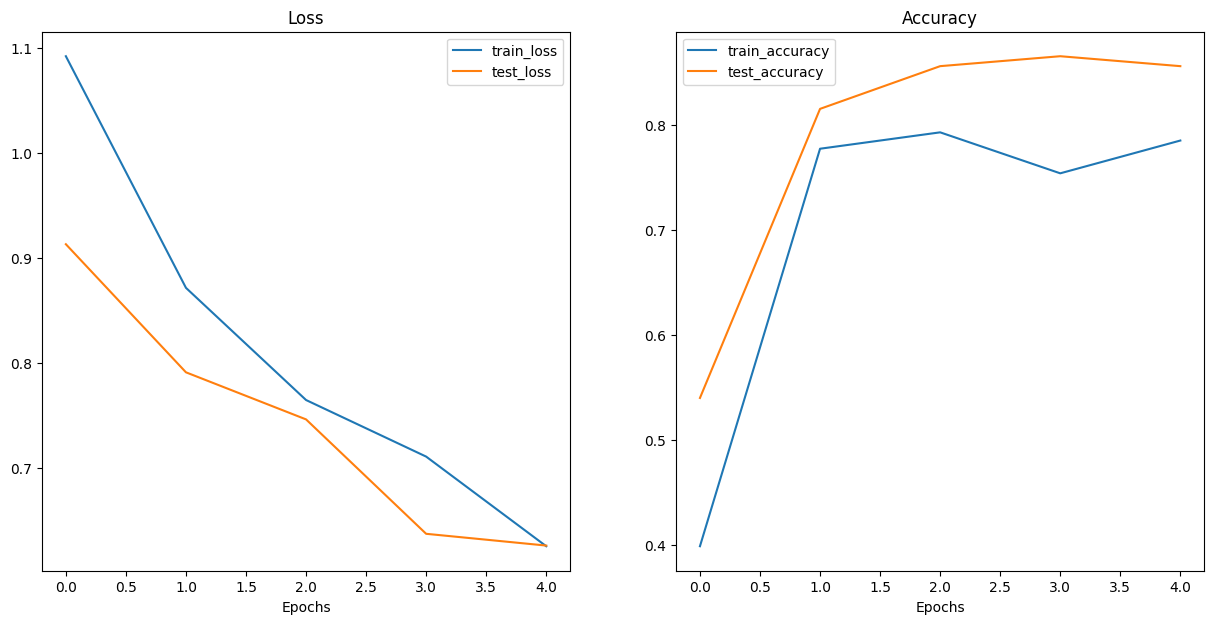

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)


## 6. Make predictions on images from the test set
Some things to keep in mide when making prediction/inference on test/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model it was trained on
* Same datatype - custom data should be in the same data type
* same device - custom/test data should be on the same device as the model
* same transform - if you've transformed your data, ideally you will transform the test data and custom data as the same

To do all of this automatically, let's create a function called `pred_plot_image()`:

1. Take in a trained mode, list of class names, a filepath to target image, an image size, a transform and target device
2. Open an image with `PIL.Image.open()`.
3. Create a transform for the image (this will default to the manual_transforms we created above or it could use a transform generated from weights.transforms()).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with torch.unsqueeze(dim=0) so our input image has shape [batch_size, color_channels, height, width].
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with torch.`softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with matplotlib and set the title to the prediction label from step 9 and prediction probability from step 8.

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1.
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names: List[str],
                        image_size: Tuple[int,int]= (224,224),
                        transform: torchvision.transforms=None,
                        device: torch.device = device):
  # 2.
  img = Image.open(image_path)

  #3.
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485,0.465,0.406],
                                                               std=[0.229,0.224,0.225])
                                          ])

  ### Predict on image ###
  # 4.
  model.to(device)

  # 5.
  model.eval()
  with torch.inference_mode():
    # 6.
    transformed_image = image_transform(img).unsqueeze(dim=0) # [b,c,h,w]

    # 7.
    target_image_pred = model(transformed_image.to(device))

  # 8.
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

  # 9.
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)


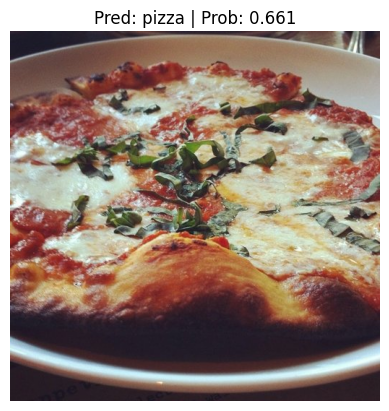

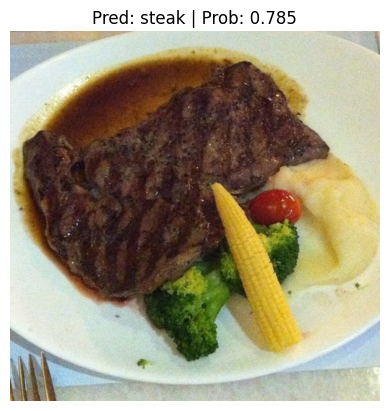

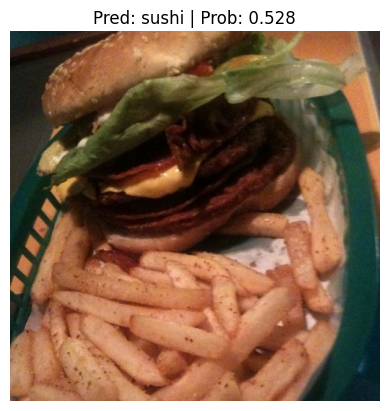

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

### 6.1 Making predictions on a custom image

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists")

data/04-pizza-dad.jpeg already exists


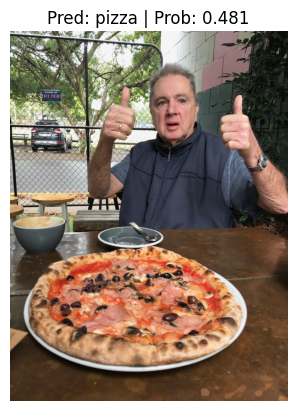

In [ ]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)